In [2]:
import numpy as np
import pandas as pd
import os
from glob import glob
from pprint import pprint
import json
import seaborn as sns
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt

import cellcycle.PlottingTools as plottingTools
from cellcycle.ParameterSet import ParameterSet
import cellcycle.DataStorage as dataStorage
import cellcycle.DataAnalysis as dataAnalysis
import cellcycle.MakeDataframe as makeDataframe

In [3]:
distribution_sites = 'homogeneous' # options 'homogeneous' or 'inhom'
file_path = '/home/berger/Documents/Arbeit/PhD/data/UltrasensitivityCombined/NatCom/SI/S3_homogeneous/'+distribution_sites+'_int'
parameter_path = os.path.join(file_path, 'parameter_set.csv')

pinkish_red = (247 / 255, 109 / 255, 109 / 255)
green = (0 / 255, 133 / 255, 86 / 255)
dark_blue = (36 / 255, 49 / 255, 94 / 255)
light_blue = (168 / 255, 209 / 255, 231 / 255)
blue = (55 / 255, 71 / 255, 133 / 255)
yellow = (247 / 255, 233 / 255, 160 / 255)
dark_yellow = (235 / 255, 201 / 255, 27 / 255)

In [4]:
data_frame = makeDataframe.make_dataframe(file_path)
data_frame = makeDataframe.add_average_values_to_df(data_frame)
data_frame = makeDataframe.add_theoretical_init_reg_concentrations_to_df(data_frame)
data_frame.path_dataset

['/home/berger/Documents/Arbeit/PhD/data/UltrasensitivityCombined/test_output/vary_growth_rate']


0    /home/berger/Documents/Arbeit/PhD/data/Ultrase...
Name: path_dataset, dtype: object

# Calculate initiator concentration, initiation volume and theoretical division and birth volume

In [5]:
def return_last_initiator_conc_at_t_init_from_path(filepath_h5):
    data_frame = pd.read_hdf(filepath_h5, key='dataset_init_events')
    v_init = data_frame.iloc[-1]['v_init']
    n_init = data_frame.iloc[-1]['n_init']
    return n_init / v_init
    
data_frame["init_conc_at_t_init"] = data_frame.apply(lambda row: return_last_initiator_conc_at_t_init_from_path(row.path_dataset), axis=1)


In [6]:
from scipy.optimize import fsolve
    
def solve_initiation_volume_analytically(z, diss_constant_sites, total_conc, sites_total, critical_free_conc):
    volume = z[0]
    sum_1 = diss_constant_sites + sites_total / volume + (volume * total_conc) / volume
    free_conc = total_conc - sum_1 / 2 + np.sqrt(
        sum_1 ** 2 - 4 * (sites_total / volume) * total_conc )/2
    F = free_conc-critical_free_conc
    return F

data_frame.loc[:,"v_init_per_n_ori_th_solved_exact_conc"]= data_frame.apply(
    lambda row: fsolve(solve_initiation_volume_analytically, 
                       row.v_init_per_n_ori, args=(row. diss_constant_sites, row.init_conc_at_t_init, row.n_c_max_0, row.critical_free_conc))[0], axis=1)


In [7]:
data_frame["v_d_th"] = data_frame.apply(lambda row: row.v_init_per_n_ori_th_solved_exact_conc * 2**(row.t_CD *row.doubling_rate), axis=1)
data_frame["v_b_th"] = data_frame.apply(lambda row: row.v_d_th / 2, axis=1)
v_b_th = data_frame.iloc[0]['v_b_th']
# data_frame["v_b_th"]

# Plot time traces of volumes

In [8]:
data_frame = makeDataframe.make_dataframe(file_path)
time_traces_data_frame = pd.read_hdf(data_frame['path_dataset'].iloc[0], key='dataset_time_traces')

v_init_data_frame = pd.read_hdf(data_frame['path_dataset'].iloc[0], key='dataset_init_events')
v_init = v_init_data_frame.iloc[-1]['v_init']
v_init_list = v_init_data_frame['v_init_per_ori'].to_numpy()
v_init_per_ori = v_init_data_frame.iloc[-1]['v_init_per_ori']
t_init_list = v_init_data_frame['t_init'].to_numpy()

v_d_data_frame = pd.read_hdf(data_frame['path_dataset'].iloc[0], key='dataset_div_events')
t_div_list = v_d_data_frame['t_d'].to_numpy()

['/home/berger/Documents/Arbeit/PhD/data/UltrasensitivityCombined/test_output/vary_growth_rate']


In [9]:
time = np.array(time_traces_data_frame["time"])
volume = np.array(time_traces_data_frame["volume"])
n_ori = np.array(time_traces_data_frame["n_ori"])
n_p = np.array(time_traces_data_frame["N_init"])
n_s = np.array(time_traces_data_frame["sites_total"])
total_conc = n_p / volume
free_conc = np.array(time_traces_data_frame["free_conc"])
print(time.size)
t_0 = time[volume==v_d_data_frame['v_b'][9]]
indx_0 = np.where(time==t_0)[0][0]
t_f = time[volume==v_d_data_frame['v_b'][15]]
indx_f = np.where(time==t_f)[0][0]+20

print(indx_0, indx_f)

n_ori_cut = n_ori[indx_0:indx_f]
time_cut = time[indx_0:indx_f]
volume_cut = volume[indx_0:indx_f]
n_ori_density_cut = n_ori_cut / volume_cut
n_p_cut = n_p[indx_0:indx_f]
n_s_cut = n_s[indx_0:indx_f]
total_conc_cut = total_conc[indx_0:indx_f]
free_conc_cut = free_conc[indx_0:indx_f]

t_init_list_cut_1 = t_init_list[t_init_list>t_0]
t_init_list_cut = t_init_list_cut_1[t_init_list_cut_1<t_f]

v_init_list_cut_1 = v_init_list[t_init_list>t_0]
v_init_list_cut = v_init_list_cut_1[t_init_list_cut_1<t_f]

t_div_list_cut_1 = t_div_list[t_div_list>t_0]
t_div_list_cut = t_div_list_cut_1[t_div_list_cut_1<=t_f]
print(t_div_list_cut, t_f)

11667
6923 10445
[ 7.094  8.09   8.261  9.258  9.429 10.425] [10.425]


0.5833333333284721 6.923 7.764572107178216


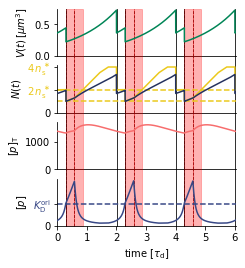

In [10]:
label_list = [r'$V(t) \, [\mu m^3]$', r'$N(t)$', r'$[p]_{\rm T}$', r'$[p]$']
x_axes_list = [time_cut, time_cut, time_cut, time_cut]
y_axes_list = [volume_cut, n_p_cut, total_conc_cut, free_conc_cut]
color_list = [green, dark_blue, pinkish_red, blue]
y_min_list = [0,0,0,0]
y_max_list = [1, 1.2, 1.2, 1.2]

doubling_time = 1/data_frame.iloc[0]['doubling_rate']
fig, ax = plt.subplots(4, figsize=(3.2,4))
plt.xlabel(r'time [$\tau_{\rm d}$]')
for item in range(0, len(label_list)):
    if item == 1:
        ax[item].plot(time_cut, n_s_cut, color=dark_yellow, zorder=2)
    ax[item].set_ylabel(label_list[item])
    ax[item].plot(x_axes_list[item], y_axes_list[item], color=color_list[item], zorder=3)
    ax[item].set_ylim(ymin=0)
    ax[item].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    ax[item].spines["top"].set_visible(False)
    ax[item].spines["right"].set_visible(False)
    ax[item].margins(0)
    for t_div in t_div_list_cut:
        ax[item].axvline(x=t_div, 
                          ymin=y_min_list[item],
                          ymax=y_max_list[item],
                             c="black",
                          zorder=0, 
                          linewidth=0.8,
                          clip_on=False)
    for t_init in t_init_list_cut:
        ax[item].axvline(x=t_init, 
                          ymin=y_min_list[item],
                          ymax=y_max_list[item],
                             c="black",
                          zorder=0, 
                          linewidth=0.8,
                          linestyle='--',
                          clip_on=False)
        ax[item].axvspan(t_init, 
                 t_init + data_frame.iloc[0]['period_blocked'], 
                  ymin=y_min_list[item],
                  ymax=y_max_list[item],
                 alpha=0.3, 
                 color='red', 
                 linewidth=0.8,
                 clip_on=False)
if data_frame.iloc[0]['homogeneous_dist_sites']==0:
    ax[0].set_yticks([0,  v_init_per_ori, 2* v_init_per_ori])
    ax[0].set_yticklabels(['0', r'$v^\ast$', r'$2 \, v^\ast$'])
    ax[0].get_yticklabels()[1].set_color(color_list[0])
    ax[0].get_yticklabels()[2].set_color(color_list[0])
    ax[0].axhline(y=2 * v_init, color=green, linestyle='--', label=r'$2 \, v^\ast$')
    ax[0].axhline(y=v_init, color=green, linestyle='--', label=r'$v^\ast$')


ax[1].set_yticks([0,2* data_frame.iloc[0]['n_c_max_0'],4 * data_frame.iloc[0]['n_c_max_0']])
ax[1].set_yticklabels(['0', r'$2 \, n_{\rm s}^\ast$', r'$4 \, n_{\rm s}^\ast$'])
ax[1].get_yticklabels()[1].set_color(dark_yellow)
ax[1].get_yticklabels()[2].set_color(dark_yellow)
ax[1].axhline(y=[2*data_frame.iloc[0]['n_c_max_0']], color=dark_yellow, linestyle='--')
ax[1].axhline(y=[data_frame.iloc[0]['n_c_max_0']], color=dark_yellow, linestyle='--')

ax[2].set(ylim=(0,total_conc_cut[-1]*1.25))

ax[3].axhline(y=data_frame.iloc[0]['critical_free_conc'], color=color_list[3], linestyle='--')
ax[3].set_yticks([0, data_frame.iloc[0]['critical_free_conc']])
ax[3].set_yticklabels(['0', r'$K_{\rm D}^{\rm ori}$'])
ax[3].get_yticklabels()[1].set_color(color_list[3])
ax[3].tick_params(bottom=True, labelbottom=True)
ax[3].tick_params(axis='x', colors='black')

ax[3].set_xticks([time_cut[0], 
                  time_cut[0]+ doubling_time, 
                  time_cut[0]+ 2*doubling_time, 
                  time_cut[0]+ 3*doubling_time, 
                  time_cut[0]+ 4*doubling_time, 
                  time_cut[0]+ 5*doubling_time, 
                  time_cut[0]+ 6*doubling_time])
ax[3].set_xticklabels(['0', '1', '2', '3', '4', '5', '6'])
ax[3].margins(0)
ax[3].tick_params(     # ticks along the bottom edge are off
    bottom=True,         # ticks along the top edge are off
    labelbottom=True)

print(doubling_time, time_cut[0], time_cut[0]+ doubling_time / np.log(2))
plt.savefig(file_path + '/SI_AIT_'+distribution_sites+'_overlap.pdf', format='pdf',bbox_inches='tight')

# Plot initiation volume over time

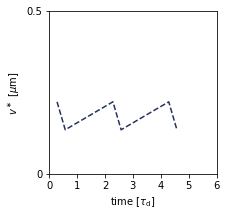

In [10]:
def return_array_of_initiation_volumes(filepath_h5):
    data_frame = pd.read_hdf(filepath_h5, key='dataset_init_events')
    return data_frame['v_init_per_ori'], data_frame['t_init']

for index, row in data_frame.iterrows():
    fig, ax = plt.subplots(figsize=(3,3))
    v_init_per_ori, t_init = return_array_of_initiation_volumes(row.path_dataset)
    delta_0 = v_init_per_ori[row.cycle_with_error+1]-v_init_per_ori[0]
#     ax.plot(t_init_list_cut, v_init_per_ori, 'o', color=dark_blue)
    ax.plot(t_init_list_cut, v_init_list_cut, '--', color=dark_blue)
    ax.set(xlabel=r'time [$\tau_{\rm d}$]', ylabel=r'$v^\ast$ [$\mu$m]')
#     ax.legend()
    ax.set_yticks([0, 0.5])
    ax.set_yticklabels(['0','0.5'])
    ax.set_xticks([time_cut[0], 
                  time_cut[0]+ doubling_time, 
                  time_cut[0]+ 2*doubling_time, 
                  time_cut[0]+ 3*doubling_time, 
                  time_cut[0]+ 4*doubling_time, 
                  time_cut[0]+ 5*doubling_time, 
                  time_cut[0]+ 6*doubling_time])
    ax.set_xticklabels(['0', '1', '2', '3', '4', '5', '6'])
#     ax.margins(0)
    ax.tick_params(     # ticks along the bottom edge are off
        bottom=True,         # ticks along the top edge are off
        labelbottom=True)
plt.savefig(file_path + '/' + data_frame.iloc[index]["simu_name"] + '_init_volume_over_time_with_th.pdf', format='pdf', bbox_inches='tight')
